In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from dataset import build_vocab
from utils import *
from models import *

In [2]:
# transforms
tt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [3]:
vocab = build_vocab('data.json')
checkpoint = load_checkpoint('models/BEST_checkpoint_flickr8k_5_cap_per_img_2_min_word_freq_resnet101_fullvocab_fix_ds_2_finetune.pth.tar')

100%|██████████| 40000/40000 [00:00<00:00, 295794.82it/s]


Loaded Checkpoint!!
Last Epoch: 10
Best Bleu-4: 0.1607200452757974


In [4]:
len(vocab)

5089

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda')

In [11]:
encoder = checkpoint['encoder']
decoder = checkpoint['decoder']
img_path = 'test_examples/dog.jpg'

a dog is standing on a beach with a dog in the sand


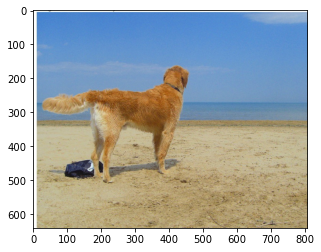

In [12]:
#def cap_image(encoder, decoder, image_path, vocab):
vocab_size = len(vocab)


img = Image.open(img_path).convert("RGB")
img = tt(img).unsqueeze(0) # transform and batch
img = img.to(device)

#encoder
encoder_out = encoder(img) # [1, enc img size, enc img size, encoder_dim]
enc_img_size = encoder_out.size(1)
encoder_dim = encoder_out.size(3)

#flatten encoder output
encoder_out = encoder_out.view(1, -1, encoder_dim) # [1, num pixels, encoder dim]
num_pixels = encoder_out.size(1)

prev_word = torch.LongTensor([vocab.stoi['<sos>']]).to(device)

seq = list()

step = 1
h, c = decoder.init_hidden_state(encoder_out)

while True:
    embeddings = decoder.embedding(prev_word).squeeze(1)
    awe, alpha = decoder.attention(encoder_out, h)

    alpha = alpha.view(-1, enc_img_size, enc_img_size)

    gate = decoder.sigmoid(decoder.f_beta(h))
    awe = gate * awe

    h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))

    scores = decoder.fc(h)
    scores = F.log_softmax(scores, dim=1)

    top = scores.argmax(1)
    
    if vocab.itos[top.item()] == '<eos>' or step > 50:
        break    
    step += 1
    seq.append(top.item())
    prev_word = top

print(" ".join([vocab.itos[idx] for idx in seq]))
show_image(image=img_path, file_name=True)